# Task 1
Responda a cada de las siguientes preguntas de forma clara y lo más completamente posible.
### 1. ¿Qué es un Markov Decision Process (MDP)?
Es un modelo para describir problemas donde un agente toma decisiones paso a paso dentro de un entorno incierto. “Markov” significa que lo único que importa para decidir es el estado actual y la acción que elijas ahora; el pasado no influye directamente.

---

### 2. Componentes principales de un MDP
- **Estados**: todas las situaciones posibles en las que puede estar el agente.
- **Acciones**: lo que el agente puede hacer en cada estado.
- **Dinámica o función de transición**: describe con qué probabilidad el sistema pasa de un estado a otro después de una acción.
- **Recompensa**: número (positivo o negativo) que indica qué tan buena fue la acción en ese estado.
- **Factor de descuento**: peso que se da a las recompensas futuras frente a las inmediatas.
- (Opcionales pero comunes) **Distribución inicial de estados** y **horizonte** (cuánto duran los episodios).

---

### 3. Objetivo del aprendizaje por refuerzo con MDPs
Aprender una **política** (una regla para elegir acciones en cada estado) que maximice la **recompensa total esperada** a lo largo del tiempo. En otras palabras, decidir consistentemente de forma que, en promedio, se obtenga el mayor beneficio posible.


# Task 2
El objetivo principal de este ejercicio es que simule un MDP que represente un robot que navega por un laberinto de
cuadrículas de 3x3 y evalúe una política determinada.
Por ello considere, a un robot navega por un laberinto de cuadrícula de 3x3. El robot puede moverse en cuatro
direcciones: arriba, abajo, izquierda y derecha. El objetivo es navegar desde la posición inicial hasta la posición de
meta evitando obstáculos. El robot recibe una recompensa cuando alcanza la meta y una penalización si choca
con un obstáculo

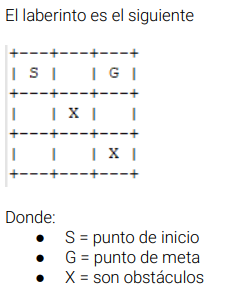

In [17]:
import numpy as np
from collections import defaultdict
import random

# Reproducibilidad
random.seed(42)
np.random.seed(42)

# --- Laberinto 3x3 ---
# Índices:
# 0 1 2
# 3 4 5
# 6 7 8

S_state = 0          # S (inicio)
G_state = 2          # G (meta)
obstacles = {4, 8}   # X (obstáculos) -> centro y esquina inferior derecha

grid_size = 3
actions = ["up", "down", "left", "right"]

# Recompensas
reward_goal = 10.0
reward_obstacle = -5.0
reward_step = -0.1   # costo por moverse (puedes poner 0 si no quieres costo)

In [18]:
def idx_to_rc(idx, n=grid_size):
    return divmod(idx, n)  # (fila, columna)

def rc_to_idx(r, c, n=grid_size):
    return r * n + c

In [19]:
P = defaultdict(lambda: defaultdict(dict))   # P[s][a] -> {s': prob}
R = defaultdict(lambda: defaultdict(dict))   # R[s][a][s'] -> reward

def step_func(s, a):
    # Estado absorbente: si ya está en la meta, permanece ahí
    if s == G_state:
        return s, 0.0
    
    r, c = idx_to_rc(s)
    nr, nc = r, c

    if a == "up":    nr -= 1
    if a == "down":  nr += 1
    if a == "left":  nc -= 1
    if a == "right": nc += 1

    # Fuera de límites -> no te mueves (solo costo de paso)
    if nr < 0 or nr >= grid_size or nc < 0 or nc >= grid_size:
        return s, reward_step

    s_next = rc_to_idx(nr, nc)

    # Obstáculo -> te quedas y penaliza
    if s_next in obstacles:
        return s, reward_obstacle

    # Meta
    if s_next == G_state:
        return s_next, reward_goal

    # Movimiento normal
    return s_next, reward_step

num_states = grid_size * grid_size
for s in range(num_states):
    for a in actions:
        s_next, rew = step_func(s, a)
        P[s][a][s_next] = 1.0
        R[s][a][s_next] = rew


In [20]:
UP, DOWN, LEFT, RIGHT = "up", "down", "left", "right"
ARROWS = {UP:"↑", DOWN:"↓", LEFT:"←", RIGHT:"→"}

def render_grid(agent=None, path=set()):
    """
    Imprime el 3x3.
    S, G, X son fijos.
    'R' es el agente.
    '·' marca celdas visitadas (path).
    """
    symbols = []
    for s in range(num_states):
        if s == S_state:
            ch = "S"
        elif s == G_state:
            ch = "G"
        elif s in obstacles:
            ch = "X"
        else:
            ch = "."

        if s in path and s not in (S_state, G_state) and s not in obstacles:
            ch = "·"

        if agent is not None and s == agent:
            ch = "R"

        symbols.append(ch)

    for r in range(grid_size):
        row = symbols[r*grid_size:(r+1)*grid_size]
        print(" ".join(row))
    print()

def render_policy(policy_dict):
    """Muestra flechas de la política en cada estado válido."""
    arrows = []
    for s in range(num_states):
        if s in obstacles:
            ch = "X"
        elif s == S_state:
            ch = "S"
        elif s == G_state:
            ch = "G"
        else:
            a = policy_dict.get(s, None)
            ch = ARROWS.get(a, ".")
        arrows.append(ch)

    for r in range(grid_size):
        print(" ".join(arrows[r*grid_size:(r+1)*grid_size]))
    print()

In [21]:
def run_episode(policy, max_steps=50, start_state=S_state, render=False):
    s = start_state
    total_reward = 0.0
    trajectory = [s]

    for _ in range(max_steps):
        a = policy.get(s, random.choice(actions))
        (s_next, _prob), = P[s][a].items()  # determinista
        reward = R[s][a][s_next]

        total_reward += reward
        s = s_next
        trajectory.append(s)

        if render:
            render_grid(agent=s, path=set(trajectory))

        if s == G_state:
            break

    return total_reward, trajectory

def evaluate_policy(policy, n_episodes=1000, max_steps=50):
    returns = []
    for _ in range(n_episodes):
        ret, _ = run_episode(policy, max_steps=max_steps)
        returns.append(ret)
    return np.mean(returns), np.std(returns)

In [22]:
random_policy = {s: random.choice(actions) for s in range(num_states)}

print("Política ALEATORIA:")
render_policy(random_policy)

ret_rand, traj_rand = run_episode(random_policy, render=False)
print(f"Recompensa episodio (aleatoria): {ret_rand:.2f}")
print("Trayectoria aleatoria:", traj_rand)
render_grid(path=set(traj_rand))

Política ALEATORIA:
S ↑ G
↓ X ↓
↑ ↑ X

Recompensa episodio (aleatoria): -5.00
Trayectoria aleatoria: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
S . G
. X .
. . X



In [23]:
alpha = 0.1      # tasa de aprendizaje
gamma = 0.99     # factor de descuento
epsilon = 1.0    # exploración inicial
epsilon_min = 0.05
epsilon_decay = 0.995
episodes = 800
max_steps = 50

action_to_idx = {a:i for i,a in enumerate(actions)}
Q = np.zeros((num_states, len(actions)))

def epsilon_greedy(s, eps):
    if random.random() < eps:
        return random.choice(actions)
    return actions[np.argmax(Q[s])]

returns = []

for ep in range(episodes):
    s = S_state
    total = 0.0

    for _ in range(max_steps):
        a = epsilon_greedy(s, epsilon)
        (s_next, _), = P[s][a].items()
        r = R[s][a][s_next]

        ai = action_to_idx[a]
        Q[s, ai] = (1-alpha)*Q[s, ai] + alpha*(r + gamma*np.max(Q[s_next]))

        total += r
        s = s_next
        if s == G_state:
            break

    returns.append(total)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if (ep+1) % 100 == 0:
        print(f"Ep {ep+1}/{episodes} - Retorno: {total:.2f} - ε={epsilon:.3f}")


Ep 100/800 - Retorno: 4.20 - ε=0.606
Ep 200/800 - Retorno: 9.90 - ε=0.367
Ep 300/800 - Retorno: 9.80 - ε=0.222
Ep 400/800 - Retorno: 9.90 - ε=0.135
Ep 500/800 - Retorno: 9.90 - ε=0.082
Ep 600/800 - Retorno: 9.90 - ε=0.050
Ep 700/800 - Retorno: 9.90 - ε=0.050
Ep 800/800 - Retorno: 9.90 - ε=0.050


In [24]:
learned_policy = {s: actions[np.argmax(Q[s])] for s in range(num_states)}

print("Política APRENDIDA:")
render_policy(learned_policy)

ret_learned, traj_learned = run_episode(learned_policy, render=False)
print(f"Recompensa con política aprendida: {ret_learned:.2f}")
print("Trayectoria aprendida:", traj_learned)
render_grid(path=set(traj_learned))

Política APRENDIDA:
S → G
↑ X ↑
↑ ← X

Recompensa con política aprendida: 9.90
Trayectoria aprendida: [0, 1, 2]
S · G
. X .
. . X



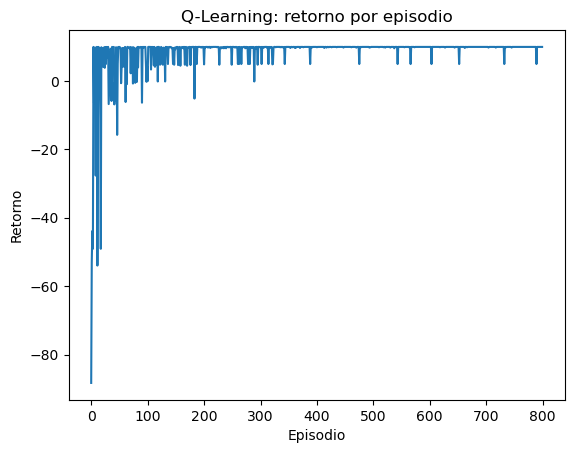

In [25]:
import matplotlib.pyplot as plt

plt.plot(returns)
plt.xlabel("Episodio")
plt.ylabel("Retorno")
plt.title("Q-Learning: retorno por episodio")
plt.show()

In [26]:
num_actions = len(actions)
T = np.zeros((num_states, num_actions, num_states))
Rmat = np.zeros((num_states, num_actions, num_states))

a_to_i = {a:i for i,a in enumerate(actions)}
for s in range(num_states):
    for a in actions:
        for s2, p in P[s][a].items():
            ai = a_to_i[a]
            T[s, ai, s2] = p
            Rmat[s, ai, s2] = R[s][a][s2]

print("T shape:", T.shape, "| R shape:", Rmat.shape)

T shape: (9, 4, 9) | R shape: (9, 4, 9)
